In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

sys.path.append("../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from preprocessing.opp_preprocess import *
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

In [4]:
data_path = '/home/hariub/data/HAR/processed/clean_opp_nodrill.csv'
df = pd.read_csv(data_path)

metadata_file = open('../configs/metadata.yaml', mode='r')
metadata = yaml.load(metadata_file, Loader=yaml.FullLoader)['opp_preprocess']
FEATURES = [str(i) for i in range(77)]
LOCO_LABEL_COL = 77
MID_LABEL_COL = 78
HI_LABEL_COL = 79
SUBJECT_ID = 80
RUN_ID = 81

# df = df[df[str(HI_LABEL_COL)] != 0]
df[FEATURES] = df[FEATURES].interpolate(method='linear', axis=0)
df = df.fillna(0)

scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

BENCHMARK_TEST = ((df[str(SUBJECT_ID)] == 2) | (df[str(SUBJECT_ID)] == 3)) & (
            (df[str(RUN_ID)] == 4) | (df[str(RUN_ID)] == 5))

train_df = df[~ BENCHMARK_TEST]
test_df = df[BENCHMARK_TEST]

SLIDING_WINDOW_LENGTH = metadata['sliding_win_len']
SLIDING_WINDOW_STEP = metadata['sliding_win_stride']
N_WINDOW, N_TIMESTEP = metadata['n_window'], metadata['n_timestep']

X_train, y_train, m_labels_tr, loco_labels_tr = create_windowed_dataset_opp(train_df, FEATURES, str(
    HI_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test, m_labels_ts, loco_labels_ts = create_windowed_dataset_opp(test_df, FEATURES, str(
    HI_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
print(X_train.shape)
print(y_train.shape)

(3183, 15, 20, 77)
(3183, 6)


In [6]:
m_labels_tr = np.asarray(m_labels_tr).reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP))
m_labels_ts = np.asarray(m_labels_ts).reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP))

In [7]:
y_train_mid = np.zeros((X_train.shape[0], N_WINDOW))
for i in range(len(y_train_mid)):
    for j in range(N_WINDOW):
        y_train_mid[i,j] = np.bincount(m_labels_tr[i, j]).argmax()
        
y_test_mid = np.zeros((X_test.shape[0], N_WINDOW))
for i in range(len(y_test_mid)):
    for j in range(N_WINDOW):
        y_test_mid[i,j] = np.bincount(m_labels_ts[i, j]).argmax()

In [8]:
y_train_mid = tf.keras.utils.to_categorical(y_train_mid)
y_test_mid = tf.keras.utils.to_categorical(y_test_mid)

In [9]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
hparams = hyperparameters['HSA_model']
hparams['modality_indices'] = hparams['modality_indices']['opp']
hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]

## Training

In [10]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
device_list = ['/gpu:'+str(i) for i in range(5, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hyperparameters['HSA_model']).get_compiled_model()

8 Physical GPUs, 8 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3


In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 20, 77)] 0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 64), ( 754112      input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_7 (Modal (None, None, 64)     104000      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 64), (None,  49856       modality_encoder_block_7[0][0]   
____________________________________________________________________________________________

In [12]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 64, epochs=30, validation_split=0.1, use_multiprocessing=True)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 288 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/devi

In [22]:
pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 64)

In [23]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76        88
           1       0.98      0.93      0.95        56
           2       0.74      0.90      0.81        88
           3       0.94      0.88      0.91       162
           4       0.71      0.93      0.80        88
           5       0.98      0.81      0.89       246

    accuracy                           0.86       728
   macro avg       0.85      0.87      0.85       728
weighted avg       0.88      0.86      0.86       728



In [24]:
import json
activity_map = json.load(open(os.path.join('..','data', 'activity_maps', 'opp_activity.json')))

In [25]:
activity_map

{'0': 'null',
 '1': 'Relaxing',
 '2': 'Coffee time',
 '3': 'Early morning',
 '4': 'Cleanup',
 '5': 'Sandwich time'}

<AxesSubplot:>

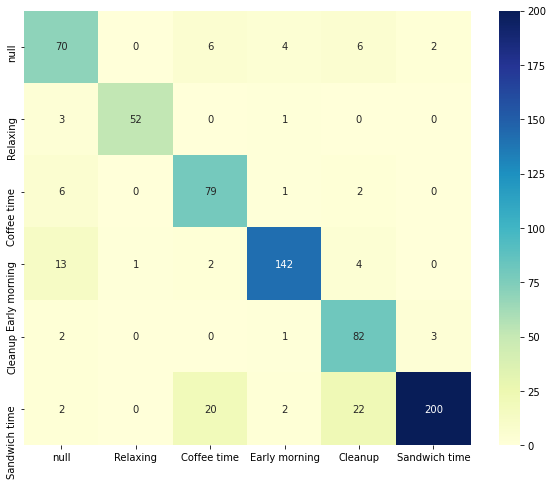

In [26]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [28]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, 18), axis=1), np.argmax(pred_mid.reshape(-1, 18), axis=1), target_names=mid_activity_opp))

                  precision    recall  f1-score   support

           Other       0.91      0.98      0.94      9123
     Open Door 1       0.52      0.34      0.42        64
     Open Door 2       0.64      0.79      0.70       107
    Close Door 1       0.68      0.25      0.37        52
    Close Door 2       0.89      0.30      0.45        82
     Open Fridge       0.67      0.52      0.59       270
    Close Fridge       0.68      0.58      0.63       182
 Open Dishwasher       0.55      0.30      0.39       119
Close Dishwasher       0.44      0.30      0.36        90
   Open Drawer 1       0.27      0.09      0.13        45
  Close Drawer 1       0.00      0.00      0.00        52
   Open Drawer 2       0.11      0.03      0.05        32
  Close Drawer 2       0.00      0.00      0.00        27
   Open Drawer 3       0.44      0.52      0.48        79
  Close Drawer 3       0.61      0.41      0.49        73
     Clean Table       0.91      0.31      0.46       101
  Drink from 

In [19]:
mid_activity_opp = ['Other', 'Open Door 1', 'Open Door 2', 'Close Door 1',
                    'Close Door 2', 'Open Fridge', 'Close Fridge', 
                    'Open Dishwasher', 'Close Dishwasher', 'Open Drawer 1', 
                    'Close Drawer 1', 'Open Drawer 2', 'Close Drawer 2', 
                    'Open Drawer 3', 'Close Drawer 3', 'Clean Table', 
                    'Drink from Cup', 'Toggle Switch']